In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
from datetime import timedelta

In [150]:
def range_data(df, init_time, end_time, delta):

    df['Time'] = pd.to_datetime(df['Time'], utc=True)
    it = pd.to_datetime(init_time) + timedelta(minutes=delta)
    et = pd.to_datetime(end_time) + timedelta(minutes=delta)

    return df[(df['Time'] >= it) & (df['Time'] <= et)]

def summary_table(original_df, evolved_df, simple_df, random_df, column_name):

    sum_table = pd.concat([original_df[column_name].describe(), 
                            evolved_df[column_name].describe(), 
                            simple_df[column_name].describe(), 
                            random_df[column_name].describe()], 
                            axis=1)
    sum_table.columns= ['Original', 'Evolved', 'Simple', 'Random']

    for column in sum_table.columns:
        for idx in sum_table.index[1:]:
            sum_table.at[idx,column] = round(sum_table.at[idx,column],3)

    return sum_table

def stat_test(evolved_df, comparable_df, column_name, comparable_df_name, metric_name):
    stat, p_value = mannwhitneyu(evolved_df[column_name], comparable_df[column_name])
    t1 = f'Evolved vs {comparable_df_name}'
    t2 = f'Mann–Whitney U Test: stat = {stat:.4f}, p-value = {p_value:.4f}'
    t3 = f'Null hypothesis: the distribution of {metric_name.lower()} is the same in the Evolved and {comparable_df_name} datasets.'
    if p_value > 0.05:
        #'Same distribution (fail to reject H0)'
        t4 = 'Result: We do not reject the null hypothesis'
    else:
        #'Different distribution, (reject H0)'
        t4 = 'Result: We reject the null hypothesis'
    return t1+'\n'+t2+'\n'+t3+'\n'+t4

def plot_results(original_df, evolved_df, simple_df, random_df, column_name, metric_name, x_lablel):
    
    sum_table = summary_table(original_df, evolved_df, simple_df, random_df, column_name)

    original_df['Dataset'] = 'Original'
    evolved_df['Dataset'] = 'Evolved'
    simple_df['Dataset'] = 'Simple'
    random_df['Dataset'] = 'Random'

    data = pd.concat([original_df, evolved_df, simple_df, random_df], ignore_index=True).reset_index(drop=True)

    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15, 15))
    sns.violinplot(x=column_name, y='Dataset', data=data, cut=0, ax=ax1)
    ax1.set_title(f'{metric_name} comparison \n')
    ax1.set_xlabel(x_lablel)
    ax2.table(cellText=sum_table.values, 
            colLabels=sum_table.columns, 
            cellLoc='center', 
            rowLabels=sum_table.index,
            bbox=(0, 0.5, 1, 0.5))
    ax2.text(0, 0.35, stat_test(evolved_df, original_df, column_name, 'Original', metric_name))
    ax2.text(0, 0.2, stat_test(evolved_df, simple_df, column_name, 'Simple', metric_name))
    ax2.text(0, 0.05, stat_test(evolved_df, random_df, column_name, 'Random', metric_name))
    ax2.axis('off')

    plt.show()



In [151]:
# Original time
ori_it, ori_et = '2022-09-27T11:13:00Z','2022-09-27T13:31:00Z'
#Diversified time
evo_it, evo_et = '2022-10-28T02:19:10Z','2022-10-28T05:11:59Z'
# Expanded dummy
sim_it, sim_et = '2022-10-27T05:17:51Z','2022-10-27T08:09:56Z'
# Expanded Random
ran_it, ran_et = '2022-10-27T22:53:43Z','2022-10-28T01:42:16Z'

ori = pd.read_csv('Rsults/Normal/Error Ratios-data-as-seriestocolumns-2022-09-27 15 18 49.csv',skiprows=1)
evo = pd.read_csv('Rsults/Diversified/Error Ratios-data-2022-10-28 05 32 40.csv', skiprows=1)
sim = pd.read_csv('Rsults/Normal_dummy/Error Ratios-data-2022-10-27 09 04 46.csv', skiprows=1)
ran = pd.read_csv('Rsults/Normal_random/Error Ratios-data-2022-10-28 01 47 50.csv', skiprows=1)

ori = ori[['Time', 'postgres service']]
ori = ori.dropna(axis=0)

evo = ori.copy()
sim = ori.copy()
ran = ori.copy()
# ori = range_data(ori, ori_it, ori_et,4)
# evo = range_data(ori, evo_it, evo_et,1)
# sim = range_data(ori, sim_it, sim_et,1)
# ran = range_data(ori, ran_it, ran_et,1)

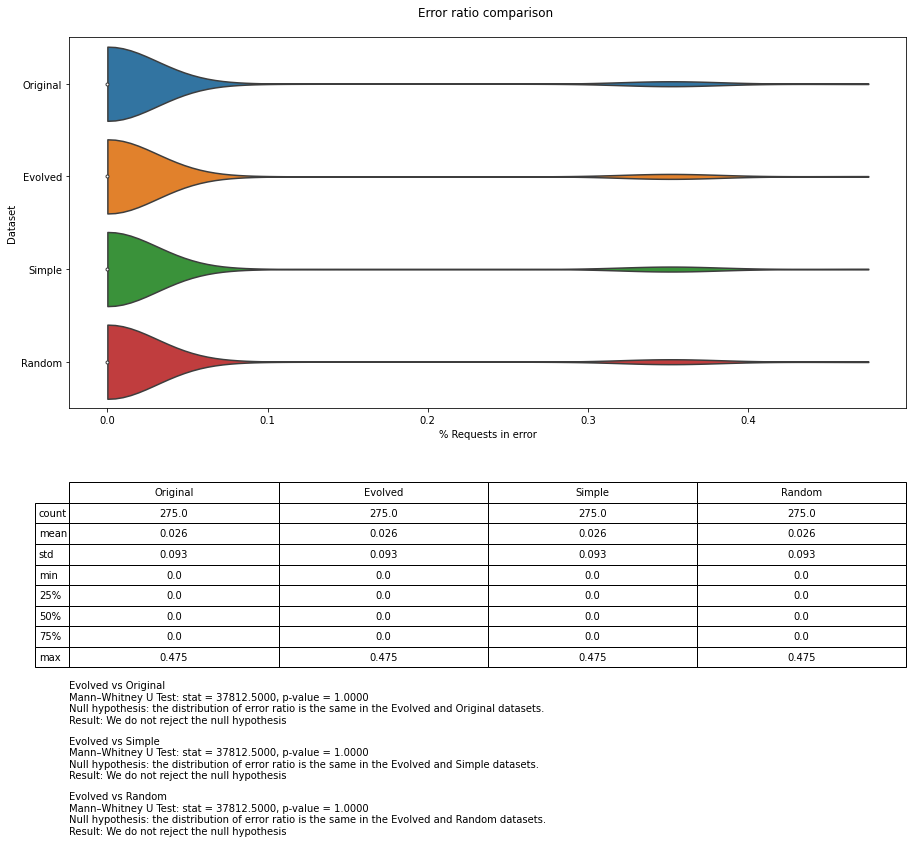

In [152]:
plot_results(ori, evo, sim, ran, 'postgres service', 'Error ratio', '% Requests in error')

In [85]:
#Diversified time
init_time, end_time = '2022-10-28T02:19:10Z','2022-10-28T05:11:59Z'
d_error_ratio = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Diversified/Error Ratios-data-2022-10-28 05 32 40.csv', skiprows=1)
d_memory_util = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Diversified/Memory Utilization-data-2022-10-28 05 33 49.csv', skiprows=1)
d_rps = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Diversified/RPS - Service Requests per Second-data-2022-10-28 05 32 58.csv', skiprows=1)
d_latency = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Diversified/Workhorse Latency-data-as-seriestocolumns-2022-10-28 05 34 46.csv',skiprows=1)
d_saturation = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Diversified/Saturation-data-as-seriestocolumns-2022-10-28 05 31 43.csv', skiprows=1)

d_error_ratio = range_data(d_error_ratio, init_time, end_time)
d_memory_util = range_data(d_memory_util, init_time, end_time)
d_rps = range_data(d_rps, init_time, end_time)
d_latency = range_data(d_latency, init_time, end_time)
d_saturation = range_data(d_saturation, init_time, end_time)

In [86]:
# Original time
init_time, end_time = '2022-09-27T11:13:00Z','2022-09-27T13:31:00Z'
n_error_ratio = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal/Error Ratios-data-as-seriestocolumns-2022-09-27 15 18 49.csv',skiprows=1)
n_memory_util = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal/Memory Utilization-data-2022-09-27 15 18 13.csv',skiprows=1)
n_rps = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal/RPS - Service Requests per Second-data-2022-09-27 15 19 23.csv',skiprows=1)
n_latency = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal/Workhorse Latency-data-as-seriestocolumns-2022-09-27 15 21 52.csv',skiprows=1)
n_saturation = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal/Saturation-data-as-seriestocolumns-2022-09-27 15 21 00.csv', skiprows=1)

n_error_ratio = range_data(n_error_ratio, init_time, end_time)
n_memory_util = range_data(n_memory_util, init_time, end_time)
n_rps = range_data(n_rps, init_time, end_time)
n_latency = range_data(n_latency, init_time, end_time)
n_saturation = range_data(n_saturation, init_time, end_time)

In [87]:
# Expanded dummy
init_time, end_time = '2022-10-27T05:17:51Z','2022-10-27T08:09:56Z'
e_error_ratio = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal_dummy/Error Ratios-data-2022-10-27 09 04 46.csv', skiprows=1)
e_memory_util = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal_dummy/Memory Utilization-data-2022-10-27 09 05 21.csv', skiprows=1)
e_rps = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal_dummy/RPS - Service Requests per Second-data-2022-10-27 09 05 03.csv', skiprows=1)
e_latency = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal_dummy/Workhorse Latency-data-as-seriestocolumns-2022-10-27 09 04 21.csv', skiprows=1)
e_saturation = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal_dummy/Saturation-data-as-seriestocolumns-2022-10-27 09 04 00.csv', skiprows=1)

e_error_ratio = range_data(e_error_ratio, init_time, end_time)
e_memory_util = range_data(e_memory_util, init_time, end_time)
e_rps = range_data(e_rps, init_time, end_time)
e_latency = range_data(e_latency, init_time, end_time)
e_saturation = range_data(e_saturation, init_time, end_time)


In [88]:
# Expanded Random

init_time, end_time = '2022-10-27T22:53:43Z','2022-10-28T01:42:16Z'
r_error_ratio = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal_random/Error Ratios-data-2022-10-28 01 47 50.csv', skiprows=1)
r_memory_util = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal_random/Memory Utilization-data-2022-10-28 01 48 59.csv', skiprows=1)
r_rps = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal_random/RPS - Service Requests per Second-data-2022-10-28 01 48 10.csv', skiprows=1)
r_latency = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal_random/Workhorse Latency-data-as-seriestocolumns-2022-10-28 01 46 58.csv', skiprows=1)
r_saturation = pd.read_csv('/Users/francisco/Library/CloudStorage/OneDrive-Personal/Uni of Adelaide/Socialz/Socialz/Data/Rsults/Normal_random/Saturation-data-as-seriestocolumns-2022-10-28 01 47 32.csv', skiprows=1)

r_error_ratio = range_data(r_error_ratio, init_time, end_time)
r_memory_util = range_data(r_memory_util, init_time, end_time)
r_rps = range_data(r_rps, init_time, end_time)
r_latency = range_data(r_latency, init_time, end_time)
r_saturation = range_data(r_saturation, init_time, end_time)


In [79]:
error_ratio = pd.concat([d_error_ratio['postgres service'].describe(), e_error_ratio['postgres service'].describe(), r_error_ratio['postgres service'].describe()], axis=1)
error_ratio.columns= ['Divirsified', 'Expanded Dummy', 'Expanded Random']
error_ratio

,Divirsified,Expanded Dummy,Expanded Random
count,172.000000,29.0,169.000000
mean,0.000029,0.0,0.000002
std,0.000384,0.0,0.000021
min,0.000000,0.0,0.000000
25%,0.000000,0.0,0.000000
50%,0.000000,0.0,0.000000
75%,0.000000,0.0,0.000000
max,0.005030,0.0,0.000279


<AxesSubplot:xlabel='postgres service', ylabel='Dataset'>

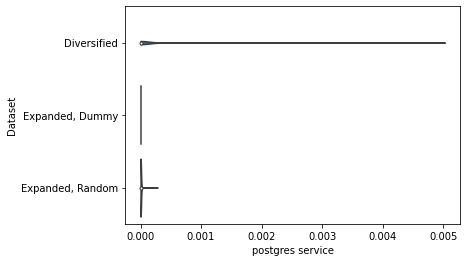

In [80]:
# Error ratio:
# Drop column gitlab-workhorse service, add column 'Dataset' to diferenciate experiments.

#d_error_ratio.drop('gitlab-workhorse service',axis=1 ,inplace=True)
d_error_ratio['Dataset'] = 'Diversified'

# n_error_ratio.drop('gitlab-workhorse service',axis=1 ,inplace=True)
# n_error_ratio['Dataset'] = 'Original'

e_error_ratio['Dataset'] = 'Expanded, Dummy'
r_error_ratio['Dataset'] = 'Expanded, Random'

data = pd.concat([n_error_ratio, d_error_ratio, e_error_ratio, r_error_ratio])
sns.violinplot(x='postgres service', y='Dataset', data=data, cut=0)

In [93]:
stat, p_value = mannwhitneyu(d_error_ratio['postgres service'], e_error_ratio['postgres service'])
print(f'Mann–Whitney U Test: stat = {stat:.4f}, p-value = {p_value:.4f}')
print('Null hypothesis: the distribution of error ratio is the same in the original and diversified datasets.')
if p_value > 0.05:
    #'Same distribution (fail to reject H0)'
    print('Result: We do not reject the null hypothesis')
else:
    #'Different distribution, (reject H0)'
    print('Result: We reject the null hypothesis')

Mann–Whitney U Test: stat = 2508.5000, p-value = 0.6918
Null hypothesis: the distribution of error ratio is the same in the original and diversified datasets.
Result: We do not reject the null hypothesis


In [94]:
stat, p_value = mannwhitneyu(d_error_ratio['postgres service'], r_error_ratio['postgres service'])
print(f'Mann–Whitney U Test: stat = {stat:.4f}, p-value = {p_value:.4f}')
print('Null hypothesis: the distribution of error ratio is the same in the original and diversified datasets.')
if p_value > 0.05:
    #'Same distribution (fail to reject H0)'
    print('Result: We do not reject the null hypothesis')
else:
    #'Different distribution, (reject H0)'
    print('Result: We reject the null hypothesis')

Mann–Whitney U Test: stat = 14533.0000, p-value = 0.9967
Null hypothesis: the distribution of error ratio is the same in the original and diversified datasets.
Result: We do not reject the null hypothesis


In [89]:
# Memory utilisation:
# Rename columns, add column 'Dataset' to diferenciate experiments.

# n_memory_util.columns = ['Time', 'Memory utilisation']
# n_memory_util['Dataset'] = 'Original'

d_memory_util.columns = ['Time', 'Memory utilisation']
d_memory_util['Dataset'] = 'Diversified'

e_memory_util.columns = ['Time', 'Memory utilisation']
e_memory_util['Dataset'] = 'Expanded, Dummy'

r_memory_util.columns = ['Time', 'Memory utilisation']
r_memory_util['Dataset'] = 'Expanded, Random'


mem_util = pd.concat([d_memory_util['Memory utilisation'].describe(),e_memory_util['Memory utilisation'].describe(),r_memory_util['Memory utilisation'].describe()],axis=1)
mem_util.columns= ['Divirsified', 'Expanded, Dummy', 'Expanded, Random']
mem_util

,Divirsified,"Expanded, Dummy","Expanded, Random"
count,172.000000,86.000000,169.000000
mean,0.737640,0.735709,0.705308
std,0.006227,0.006896,0.007202
min,0.716000,0.721000,0.679000
25%,0.733000,0.731000,0.700000
50%,0.737000,0.734000,0.705000
75%,0.742000,0.740000,0.710000
max,0.765000,0.753000,0.726000


<AxesSubplot:xlabel='Memory utilisation', ylabel='Dataset'>

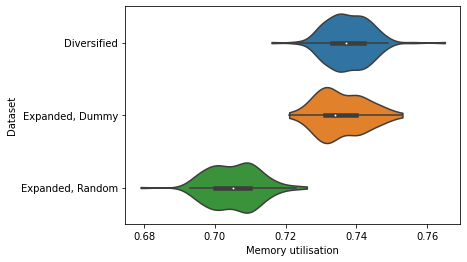

In [90]:
data = pd.concat([d_memory_util, e_memory_util, r_memory_util])
sns.violinplot(x='Memory utilisation', y='Dataset', data=data, cut=0)

In [91]:
stat, p_value = mannwhitneyu(d_memory_util['Memory utilisation'], e_memory_util['Memory utilisation'])
print(f'Mann–Whitney U Test: stat = {stat:.4f}, p-value = {p_value:.4f}')
print('Null hypothesis: the distribution of memory utilization ratios is the same in the original and diversified datasets.')
if p_value > 0.05:
    #'Same distribution (fail to reject H0)'
    print('Result: We do not reject the null hypothesis')
else:
    #'Different distribution, (reject H0)'
    print('Result: We reject the null hypothesis')

Mann–Whitney U Test: stat = 8792.0000, p-value = 0.0134
Null hypothesis: the distribution of memory utilization ratios is the same in the original and diversified datasets.
Result: We reject the null hypothesis


In [92]:
stat, p_value = mannwhitneyu(d_memory_util['Memory utilisation'], r_memory_util['Memory utilisation'])
print(f'Mann–Whitney U Test: stat = {stat:.4f}, p-value = {p_value:.4f}')
print('Null hypothesis: the distribution of memory utilization ratios is the same in the original and diversified datasets.')
if p_value > 0.05:
    #'Same distribution (fail to reject H0)'
    print('Result: We do not reject the null hypothesis')
else:
    #'Different distribution, (reject H0)'
    print('Result: We reject the null hypothesis')

Mann–Whitney U Test: stat = 29054.5000, p-value = 0.0000
Null hypothesis: the distribution of memory utilization ratios is the same in the original and diversified datasets.
Result: We reject the null hypothesis


In [95]:
# Requests per second (RPS)
# Rename columns

#n_rps.columns = ['Time', 'RPS']
d_rps.columns = ['Time', 'RPS']
e_rps.columns = ['Time', 'RPS']
r_rps.columns = ['Time', 'RPS']
rps = pd.concat([d_rps['RPS'].describe(), e_rps['RPS'].describe(), r_rps['RPS'].describe()],axis=1)
rps.columns= ['Divirsified', 'Expanded, Dummy', 'Expanded, Random']
rps

,Divirsified,"Expanded, Dummy","Expanded, Random"
count,172.000000,29.000000,169.000000
mean,1.750977,1.918797,1.735137
std,1.262201,1.261072,1.074629
min,0.167000,0.011100,0.022200
25%,1.120000,1.380000,1.130000
50%,1.350000,1.620000,1.410000
75%,1.670000,1.950000,1.730000
max,7.530000,6.460000,6.510000


<AxesSubplot:xlabel='RPS', ylabel='Dataset'>

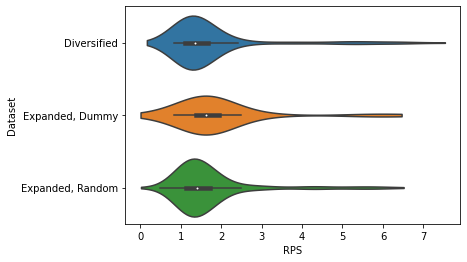

In [96]:
# add column 'Dataset' to diferenciate experiments.
#n_rps['Dataset'] = 'Original'
d_rps['Dataset'] = 'Diversified'
e_rps['Dataset'] = 'Expanded, Dummy'
r_rps['Dataset'] = 'Expanded, Random'
data = pd.concat([n_rps, d_rps, e_rps, r_rps])
sns.violinplot(x='RPS', y='Dataset', data=data, cut=0)

In [97]:
stat, p_value = mannwhitneyu(d_rps['RPS'], e_rps['RPS'])
print(f'Mann–Whitney U Test: stat = {stat:.4f}, p-value = {p_value:.4f}')
print('Null hypothesis: the distribution of requests per second is the same in the original and diversified datasets.')
if p_value > 0.05:
    #'Same distribution (fail to reject H0)'
    print('Result: We do not reject the null hypothesis')
else:
    #'Different distribution, (reject H0)'
    print('Result: We reject the null hypothesis')

Mann–Whitney U Test: stat = 1782.5000, p-value = 0.0141
Null hypothesis: the distribution of requests per second is the same in the original and diversified datasets.
Result: We reject the null hypothesis


In [98]:
stat, p_value = mannwhitneyu(d_rps['RPS'], r_rps['RPS'])
print(f'Mann–Whitney U Test: stat = {stat:.4f}, p-value = {p_value:.4f}')
print('Null hypothesis: the distribution of requests per second is the same in the original and diversified datasets.')
if p_value > 0.05:
    #'Same distribution (fail to reject H0)'
    print('Result: We do not reject the null hypothesis')
else:
    #'Different distribution, (reject H0)'
    print('Result: We reject the null hypothesis')

Mann–Whitney U Test: stat = 13643.0000, p-value = 0.3278
Null hypothesis: the distribution of requests per second is the same in the original and diversified datasets.
Result: We do not reject the null hypothesis


/var/folders/3k/tk51r55962751zt89q_rcgfw0000gn/T/ipykernel_4955/2574226169.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_cpu_saturation['Dataset'] = 'Diversified'
/var/folders/3k/tk51r55962751zt89q_rcgfw0000gn/T/ipykernel_4955/2574226169.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_cpu_saturation['Dataset'] = 'Expanded, Dummy'
/var/folders/3k/tk51r55962751zt89q_rcgfw0000gn/T/ipykernel_4955/2574226169.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

<AxesSubplot:xlabel='cpu saturation', ylabel='Dataset'>

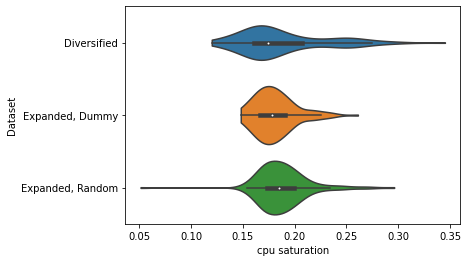

In [99]:
# CPU Saturation
# Rename columns, add column 'Dataset' to diferenciate experiments.

# n_cpu_saturation = n_saturation[['Time', 'cpu saturation']]
# n_cpu_saturation['Dataset'] = 'Original'

d_cpu_saturation = d_saturation[['Time', 'cpu saturation']]
d_cpu_saturation['Dataset'] = 'Diversified'

e_cpu_saturation = e_saturation[['Time', 'cpu saturation']]
e_cpu_saturation['Dataset'] = 'Expanded, Dummy'

r_cpu_saturation = r_saturation[['Time', 'cpu saturation']]
r_cpu_saturation['Dataset'] = 'Expanded, Random'

data = pd.concat([ d_cpu_saturation, e_cpu_saturation, r_cpu_saturation])
sns.violinplot(x='cpu saturation', y='Dataset', data=data, cut=0)

In [100]:
stat, p_value = mannwhitneyu(d_cpu_saturation['cpu saturation'], e_cpu_saturation['cpu saturation'])
print(f'Mann–Whitney U Test: stat = {stat:.4f}, p-value = {p_value:.4f}')
print('Null hypothesis: the distribution of cpu saturation ratio is the same in the original and diversified datasets.')
if p_value > 0.05:
    #'Same distribution (fail to reject H0)'
    print('Result: We do not reject the null hypothesis')
else:
    #'Different distribution, (reject H0)'
    print('Result: We reject the null hypothesis')

Mann–Whitney U Test: stat = 14214.0000, p-value = 0.5311
Null hypothesis: the distribution of cpu saturation ratio is the same in the original and diversified datasets.
Result: We do not reject the null hypothesis


In [101]:
stat, p_value = mannwhitneyu(d_cpu_saturation['cpu saturation'], r_cpu_saturation['cpu saturation'])
print(f'Mann–Whitney U Test: stat = {stat:.4f}, p-value = {p_value:.4f}')
print('Null hypothesis: the distribution of cpu saturation ratio is the same in the original and diversified datasets.')
if p_value > 0.05:
    #'Same distribution (fail to reject H0)'
    print('Result: We do not reject the null hypothesis')
else:
    #'Different distribution, (reject H0)'
    print('Result: We reject the null hypothesis')

Mann–Whitney U Test: stat = 11800.0000, p-value = 0.0027
Null hypothesis: the distribution of cpu saturation ratio is the same in the original and diversified datasets.
Result: We reject the null hypothesis


In [102]:
cpu_saturation = pd.concat([ d_cpu_saturation['cpu saturation'].describe(), e_cpu_saturation['cpu saturation'].describe(), r_cpu_saturation['cpu saturation'].describe()],axis=1)
cpu_saturation.columns = ['Diversified', 'Expanded, Dummy', 'Expanded, Random']
cpu_saturation

,Diversified,"Expanded, Dummy","Expanded, Random"
count,172.000000,172.000000,169.000000
mean,0.187430,0.180895,0.188061
std,0.042306,0.020321,0.025269
min,0.120000,0.148000,0.051300
25%,0.160750,0.167000,0.173000
50%,0.174000,0.178000,0.185000
75%,0.207250,0.191000,0.199000
max,0.345000,0.261000,0.296000


In [ ]:
# Latency:

n_latency.drop([68], inplace=True)

In [35]:
n_latency = n_latency[['Time','0.005','0.025','0.1','0.5','1','10','30','60','300','+Inf']]
n_latency.describe()

,0.005,0.025,0.1,0.5,1,10,30,60,300,+Inf
count,83.0,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.0,1.209370,2.742169,3.145663,3.163373,3.163699,3.163699,3.163699,3.163699,3.163699
std,0.0,0.997486,1.209467,1.193870,1.187590,1.186771,1.186771,1.186771,1.186771,1.186771
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.689000,2.205000,2.605000,2.640000,2.640000,2.640000,2.640000,2.640000,2.640000
50%,0.0,0.933000,2.440000,2.810000,2.840000,2.840000,2.840000,2.840000,2.840000,2.840000
75%,0.0,1.255000,2.870000,3.285000,3.285000,3.285000,3.285000,3.285000,3.285000,3.285000
max,0.0,5.240000,7.230000,7.610000,7.610000,7.610000,7.610000,7.610000,7.610000,7.610000


In [36]:
d_latency = d_latency[['Time','0.005','0.025','0.1','0.5','1','10','30','60','300','+Inf']]
d_latency.describe()

,0.005,0.025,0.1,0.5,1,10,30,60,300,+Inf
count,109.0,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,0.0,0.883902,2.409908,2.816972,2.836697,2.836697,2.836697,2.836697,2.836697,2.836697
std,0.0,0.960912,1.200956,1.166720,1.160524,1.160524,1.160524,1.160524,1.160524,1.160524
min,0.0,0.083300,1.080000,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000
25%,0.0,0.267000,1.470000,1.900000,1.930000,1.930000,1.930000,1.930000,1.930000,1.930000
50%,0.0,0.683000,2.280000,2.680000,2.720000,2.720000,2.720000,2.720000,2.720000,2.720000
75%,0.0,0.933000,2.630000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,0.0,4.630000,6.600000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [37]:
e_latency = d_latency[['Time','0.005','0.025','0.1','0.5','1','10','30','60','300','+Inf']]
e_latency.describe()

,0.005,0.025,0.1,0.5,1,10,30,60,300,+Inf
count,109.0,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,0.0,0.883902,2.409908,2.816972,2.836697,2.836697,2.836697,2.836697,2.836697,2.836697
std,0.0,0.960912,1.200956,1.166720,1.160524,1.160524,1.160524,1.160524,1.160524,1.160524
min,0.0,0.083300,1.080000,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000
25%,0.0,0.267000,1.470000,1.900000,1.930000,1.930000,1.930000,1.930000,1.930000,1.930000
50%,0.0,0.683000,2.280000,2.680000,2.720000,2.720000,2.720000,2.720000,2.720000,2.720000
75%,0.0,0.933000,2.630000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,0.0,4.630000,6.600000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


<AxesSubplot:xlabel='variable', ylabel='value'>

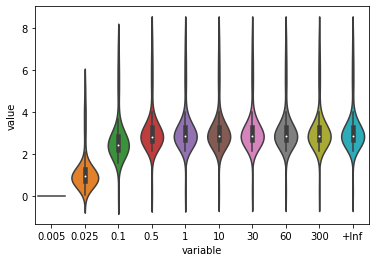

In [197]:
#Stack the columns of the summary:
n_latency = pd.melt(n_latency, id_vars=['Time'], value_vars=['0.005','0.025','0.1','0.5','1','10','30','60','300','+Inf'])
sns.violinplot(x='variable', y='value', data=n_latency)

<AxesSubplot:xlabel='variable', ylabel='value'>

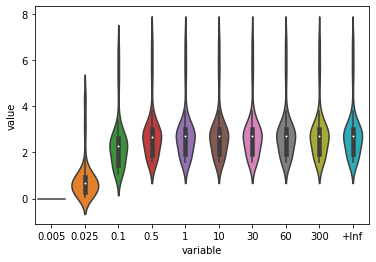

In [198]:
d_latency = pd.melt(d_latency, id_vars=['Time'], value_vars=['0.005','0.025','0.1','0.5','1','10','30','60','300','+Inf'])
sns.violinplot(x='variable', y='value', data=d_latency)

In [39]:
e_latency

,Time,variable,value
0,2022-09-27 06:38:45+00:00,0.005,0.00
1,2022-09-27 06:40:00+00:00,0.005,0.00
2,2022-09-27 06:41:15+00:00,0.005,0.00
3,2022-09-27 06:42:30+00:00,0.005,0.00
4,2022-09-27 06:43:45+00:00,0.005,0.00
...,...,...,...
1085,2022-09-27 08:48:45+00:00,+Inf,1.82
1086,2022-09-27 08:50:00+00:00,+Inf,1.93
1087,2022-09-27 08:51:15+00:00,+Inf,2.07
1088,2022-09-27 08:52:30+00:00,+Inf,2.12


In [38]:
e_latency = pd.melt(e_latency, id_vars=['Time'], value_vars=['0.005','0.025','0.1','0.5','1','10','30','60','300','+Inf'])
sns.violinplot(x='variable', y='value', data=d_latency)

ValueError: Could not interpret input 'variable'

In [201]:
buckets = ['0.005','0.025','0.1','0.5','1','10','30','60','300','+Inf']

for bucket in buckets:

    stat, p_value = mannwhitneyu(n_latency[n_latency['variable']==bucket]['value'], d_latency[d_latency['variable']==bucket]['value'])
    print(f'Mann–Whitney U Test: stat = {stat:.4f}, p-value = {p_value:.4f}')
    print(f'Null hypothesis: the distribution of {bucket} latency is the same in the original and diversified datasets.')
    if p_value > 0.05:
        #'Same distribution (fail to reject H0)'
        print('Result: We do not reject the null hypothesis')
    else:
        #'Different distribution, (reject H0)'
        print('Result: We reject the null hypothesis')
    print('\n')



Mann–Whitney U Test: stat = 4469.0000, p-value = 1.0000
Null hypothesis: the distribution of 0.005 latency is the same in the original and diversified datasets.
Result: We do not reject the null hypothesis


Mann–Whitney U Test: stat = 6166.5000, p-value = 0.0000
Null hypothesis: the distribution of 0.025 latency is the same in the original and diversified datasets.
Result: We reject the null hypothesis


Mann–Whitney U Test: stat = 5666.5000, p-value = 0.0015
Null hypothesis: the distribution of 0.1 latency is the same in the original and diversified datasets.
Result: We reject the null hypothesis


Mann–Whitney U Test: stat = 5720.0000, p-value = 0.0009
Null hypothesis: the distribution of 0.5 latency is the same in the original and diversified datasets.
Result: We reject the null hypothesis


Mann–Whitney U Test: stat = 5747.5000, p-value = 0.0007
Null hypothesis: the distribution of 1 latency is the same in the original and diversified datasets.
Result: We reject the null hypothesi